# Pattern Hunter
  
* 報告人: 吳政翰、林念頤  
* 指導者: 王均捷

# 一、整體流程

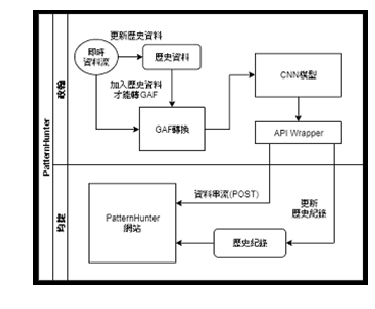

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
os.chdir(r'C:\Users\user')
plt.figure(figsize=(6,6))
g = mpimg.imread('outline.png')
plt.axis('off')
plt.imshow(g)

# 二、政翰的部分

## 自我檢核

- [x] 2019至今的分鐘資料蒐集(沒有的話日資料即可，盡量先找免費資源)
- [x] 順利使用即時價格API
- [x] 能使用CNN在下一個價格資料進來之前判斷完K線圖
- [ ] 能順利吐出訊號 (以json形式表達)

## 說明

In [2]:
target = 'S&P500'
rule = '1D'
url_his = 'https://financialmodelingprep.com/api/v3/historical-price-full/index/^GSPC'
url_real = 'https://financialmodelingprep.com/api/v3/quote/^GSPC'
his_ls = ['date', 'open', 'high', 'low', 'close', 'volume']
real_ls = ['timestamp', 'open', 'dayHigh', 'dayLow', 'price']
signal_ls = ['MorningStar', 'EveningStar', 'BearishHarami', 'BullishHarami']
save_plot = False

In [3]:
from Api_history import Api_history
from Signal2 import Signal
import util_gasf
from Cnn import CNN
from Api_realtime import Api_realtime
import util_pattern
import numpy as np
import pandas as pd
import pickle
from sklearn.utils import shuffle
from keras.models import load_model


class Main(object):
    
    def __init__(self, target, rule, url_his, url_real, his_ls, real_ls, signal_ls, save_plot):
        self.target = target
        self.rule = rule
        self.url_his = url_his
        self.url_real = url_real
        self.his_ls = his_ls
        self.real_ls = real_ls
        self.signal_ls = signal_ls
        self.save_plot = save_plot
        self.data = None
        self.data_pattern = None
        self.gasf_arr = None
        self.load_data = None
        self.load_model = None
        self.pattern_dict = dict()
        for i, j in zip(signal_ls, range(len(signal_ls))):
            self.pattern_dict[j] = i
        self.pattern_dict[len(signal_ls)] = 'No Pattern'
        self.package_realtime = None
        
    def api_history(self):
        api_his = Api_history(self.url_his, self.his_ls, self.target, self.rule)
        self.data = api_his.detect_history()
        api_his.summary_history()
        
    def rule_based(self):
        Sig = Signal(self.data, self.signal_ls, self.save_plot)
        Sig.process()
        self.data_pattern = Sig.detect_all()
        Sig.summary()
        
    def gasf(self):
        data_1D_pattern = pd.read_csv(self.data_pattern)
        gasf_arr = np.zeros((len(self.signal_ls) + 1, 30, 10, 10, 4))
        for i, j in zip(self.signal_ls, range(len(self.signal_ls))):
            gasf = util_gasf.detect(data_1D_pattern, i)
            gasf_arr[j, :, :, :, :] = gasf[0:30, :, :, :]
        df = data_1D_pattern.copy()
        for i in self.signal_ls:
            df = df.loc[df[i] != 1]
        df = shuffle(df[9::])
        gasf = util_gasf.detect(data_1D_pattern, 'n', df)
        gasf_arr[-1, :, :, :, :] = gasf[0:30, :, :, :]
        self.gasf_arr = 'gasf_arr_' + self.target
        with open(self.gasf_arr, 'wb') as handle:    
            pickle.dump(gasf_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    def process_xy(self):
        with open(self.gasf_arr, 'rb') as handle:
            gasf_arr = pickle.load(handle)
        x_arr = np.zeros(((len(self.signal_ls) + 1), 30, 10, 10, 4))
        for i in range(len(self.signal_ls) + 1):
            x_arr[i, :, :, :, :] = gasf_arr[i, 0:30, :, :, :]    
        x_arr = gasf_arr.reshape((len(self.signal_ls) + 1) * 30, 10, 10, 4)
        y_arr = []
        for i in range(len(self.signal_ls) + 1):
            ls = [i] * 30
            y_arr.extend(ls)
        y_arr = np.array(y_arr)
        load_data = {'data': x_arr, 'target': y_arr}
        self.load_data = 'load_data_' + self.target
        with open(self.load_data, 'wb') as handle:
            pickle.dump(load_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    def cnn(self):
        with open(self.load_data, 'rb') as handle:
            load_data = pickle.load(handle)
        x_arr = load_data['data']
        y_arr = load_data['target']
        model = CNN(x_arr, y_arr)
        model.process()
        model.build()
        model.train(0.2)
        model.show()
        self.load_model = 'CNN_' + self.target + '.h5'
        model.save(self.load_model)
        
    def api_realtime(self):
        api_real = Api_realtime(self.url_his, self.url_real, self.his_ls, self.real_ls) 
        self.package_realtime = api_real.detect_real() 
        
    def predict_realtime(self):
        model = load_model(self.load_model)
        if self.package_realtime != False:
            df_real, period = self.package_realtime[0], self.package_realtime[1]
            df = shuffle(df_real.iloc[9::])
            gasf = util_gasf.detect(df_real, 'n', df)
            x_realtime_arr = gasf
            y_pred_realtime = model.model.predict_classes(x_realtime_arr)
            pattern = self.pattern_dict[y_pred_realtime[0]]
            print('Target: {}'.format(self.target))
            print('Time Rule: {}'.format(self.rule))
            print('Time Period: {} - {}'.format(period[0], period[1]))
            print('The Pattern of the Realtime Data: {}'.format(pattern))
            util_pattern.pattern(df_real, self.rule, pattern)
            return (period, pattern)
        else:
            print('Not in the transaction time')
            return False

Using TensorFlow backend.


[Api_history.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/Api_history.py)  
[Signal2.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/Signal2.py)  
[util_gasf.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/util_gasf.py)  
[Cnn.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/Cnn.py)  
[Api_realtime.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/Api_realtime.py)  
[util_pattern.py](https://github.com/pecu/patternhunter/blob/%E6%94%BF%E7%BF%B0/2020_02_18/util_pattern.py)

In [4]:
main = Main(target, rule, url_his, url_real, his_ls, real_ls, signal_ls, save_plot)

### 1. 歷史資料蒐集

* 使用 [financialmodelingprep](https://financialmodelingprep.com/api/v3/historical-price-full/index/^GSPC) 的API
* 資產標的為 S&P500
* 時間尺度以「日」為單位
* 時間範圍從 2015/2/18 到 2020/2/13
* 將美國時區時間轉台灣時區時間 UTC+8
* 夏令時將台灣時區開盤時間往前調整一小時
    
美國股市交易時間:  
冬令時間 - 美東時間：早上9:30 到下午4:00；台北時間：晚上10:30到早上5:00  
夏令時間 - 美東時間：早上9:30 到下午4:00；台北時間：晚上9:30 到早上4:00  
  
美國夏至時間:  
03月10日02:00 星期日上午 - 開始 (美國時間3月11日交易時間才調整)。  
11月03日02:00 星期日上午 - 結束。

In [83]:
main.api_history()

target: S&P500
rule: 1D
Period: 2015-02-18 05:00:00 - 2020-02-14 05:00:00
shape: (1258, 6)


In [11]:
df_history = pd.read_csv('S&P500_1D_history.csv')

In [13]:
df_history.iloc[0:15].head(5)

,date,open,high,low,close,volume,realbody
0,2015-02-18 05:00:00,2096.469971,2101.300049,2089.800049,2100.340088,3.361750e+09,3.870117
1,2015-02-19 05:00:00,2099.159912,2100.229980,2092.149902,2099.679932,3.370020e+09,0.520020
2,2015-02-20 05:00:00,2099.250000,2102.129883,2090.790039,2097.449951,3.247100e+09,-1.800049
3,2015-02-21 05:00:00,2097.649902,2110.610107,2085.439941,2110.300049,3.281600e+09,12.650147
4,2015-02-24 05:00:00,2109.830078,2110.050049,2103.000000,2109.659912,3.093680e+09,-0.170166


In [14]:
df_history.iloc[16:31].head(5)

,date,open,high,low,close,volume,realbody
16,2015-03-12 04:00:00,2044.689941,2050.080078,2039.689941,2040.239990,3.406570e+09,-4.449951
17,2015-03-13 04:00:00,2041.099976,2066.409912,2041.099976,2065.949951,3.405860e+09,24.849975
18,2015-03-14 04:00:00,2064.560059,2064.560059,2041.170044,2053.399902,3.498560e+09,-11.160157
19,2015-03-17 04:00:00,2055.350098,2081.409912,2055.350098,2081.189941,3.295600e+09,25.839843
20,2015-03-18 04:00:00,2080.590088,2080.590088,2065.080078,2074.280029,3.221840e+09,-6.310059


### 2. Pattern 偵測

* 偵測範圍: 每 10 根 K 棒為單位
* 偵測的pattern: EveningStar、MorningStar、BearishHarami、BullishHarami
* 參考資料: Stephen W. Bigalow. The Major Candlesticks Signal
* EveningStar:  
趨勢上漲、第一根上漲、第二根上漲、第三根下跌  
第二根開盤價 > 第一根 1/2 的價格  
第三根收盤價 < 第一根 4/5 的價格  
MorningStar:  
趨勢下漲、第一根下跌、第二根上漲、第三根上漲  
第三根收盤價 >= 第一根 1/5 的價格  
第二根開盤價 <= 第一根 1/2 的價格  
BearishHarami:  
趨勢上漲、第一根上漲、第二根下跌  
第二根收盤價 > 第一根開盤價  
第二根開盤價 < 第一根收盤價  
BullishHarami:  
趨勢上漲、第一根上漲、第二根下跌  
第二根收盤價 > 第一根收盤價  
第二根收盤價 < 第一根開盤價







In [84]:
main.rule_based()

Rule : 1D
Period : 2015-02-19 05:00:00 - 2020-02-14 05:00:00 

Number of MorningStar : 44.0 // 1258 

Number of EveningStar : 31.0 // 1258 

Number of BearishHarami : 39.0 // 1258 

Number of BullishHarami : 30.0 // 1258 



In [51]:
df_history_pattern = pd.read_csv('S&P500_1D_pattern.csv')

In [53]:
df_history_pattern.iloc[10:20].head(5)

,open,high,low,close,volume,realbody,trend1,trend2,MorningStar,EveningStar,BearishHarami,BullishHarami
10,2115.760010,2115.760010,2098.260010,2107.780029,3.262300e+09,-7.979981,-1.0,-1.0,0.0,0.0,1.0,0.0
11,2107.719971,2107.719971,2094.489990,2098.530029,3.421110e+09,-9.189942,-1.0,-1.0,0.0,0.0,0.0,0.0
12,2098.540039,2104.250000,2095.219971,2101.040039,3.103030e+09,2.500000,-1.0,-1.0,0.0,0.0,0.0,1.0
13,2100.909912,2100.909912,2067.270020,2071.260010,3.853570e+09,-29.649902,-1.0,-1.0,0.0,0.0,0.0,0.0
14,2072.250000,2083.489990,2072.209961,2079.429932,3.349090e+09,7.179932,-1.0,-1.0,0.0,0.0,0.0,1.0


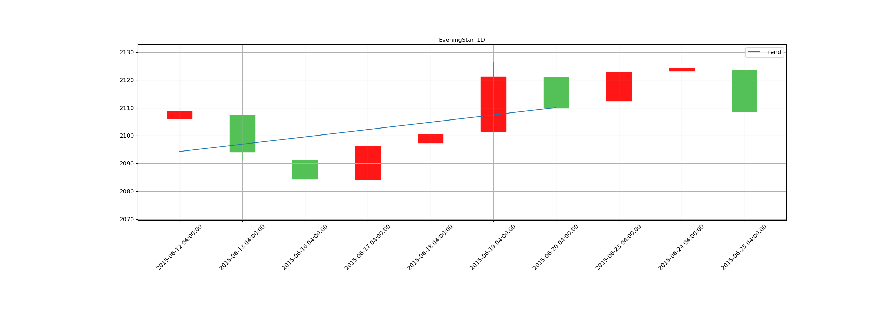

In [47]:
plt.figure(figsize=(15, 6))
g1 = mpimg.imread(r'./graph2/EveningStar_1D_2.png')
plt.axis('off')
plt.imshow(g1)

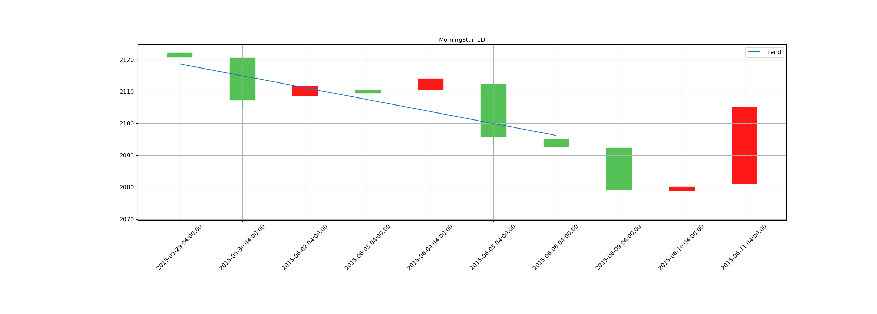

In [48]:
plt.figure(figsize=(15, 6))
g2 = mpimg.imread(r'./graph2/MorningStar_1D_5.png')
plt.axis('off')
plt.imshow(g2)

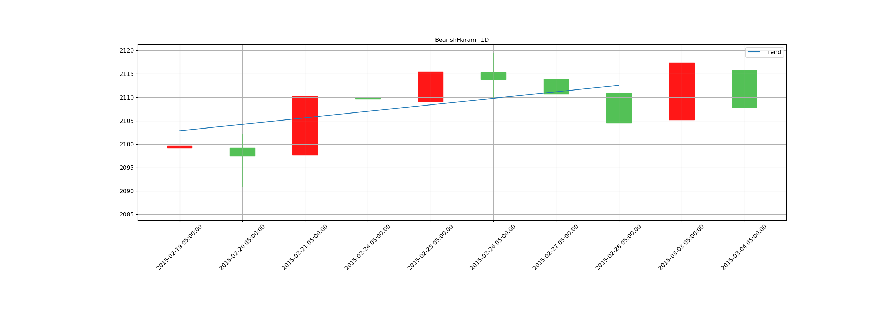

In [49]:
plt.figure(figsize=(15, 6))
g1 = mpimg.imread(r'./graph2/BearishHarami_1D_1.png')
plt.axis('off')
plt.imshow(g1)

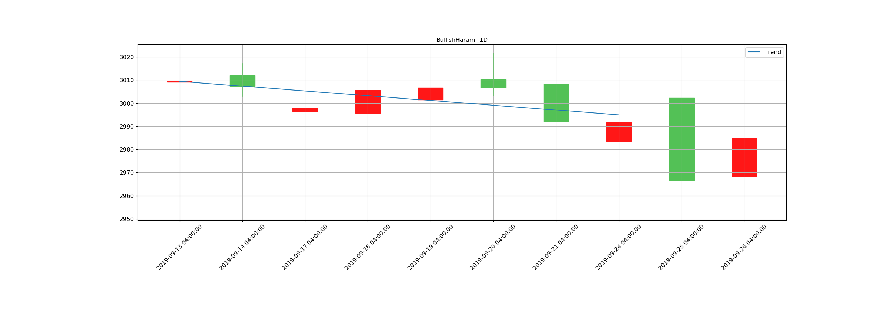

In [50]:
plt.figure(figsize=(15, 6))
g1 = mpimg.imread(r'./graph2/BullishHarami_1D_27.png')
plt.axis('off')
plt.imshow(g1)

### 3. GASF 轉換

* 將一維的時間序列資料轉換為二維的圖像資料。
* 將(150, 10, 4)的時間序列資料轉成(5, 30, 10, 10, 4)的圖像資料

In [85]:
main.gasf()

In [55]:
with open('gasf_arr_S&P500', 'rb') as handle:
    gasf_arr = pickle.load(handle)

In [57]:
gasf_arr.shape

(5, 30, 10, 10, 4)

### 4. 訓練CNN模型

* 將訓練資料集分成(150, 10, 10, 4)的影像資料與(150,)的Labels
* 未特別調整參數
* 已將訓練好的模型進行儲存

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 10, 10, 32)        544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 32)          4128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

Epoch 71/100
 - 0s - loss: 0.8424 - accuracy: 0.7024 - val_loss: 1.4131 - val_accuracy: 0.4286
Epoch 72/100
 - 0s - loss: 0.8751 - accuracy: 0.6667 - val_loss: 1.4107 - val_accuracy: 0.4286
Epoch 73/100
 - 0s - loss: 0.9089 - accuracy: 0.6429 - val_loss: 1.4058 - val_accuracy: 0.4286
Epoch 74/100
 - 0s - loss: 0.8488 - accuracy: 0.7143 - val_loss: 1.3986 - val_accuracy: 0.4286
Epoch 75/100
 - 0s - loss: 0.7996 - accuracy: 0.7024 - val_loss: 1.3934 - val_accuracy: 0.4286
Epoch 76/100
 - 0s - loss: 0.8414 - accuracy: 0.6905 - val_loss: 1.3902 - val_accuracy: 0.4286
Epoch 77/100
 - 0s - loss: 0.8612 - accuracy: 0.6548 - val_loss: 1.3898 - val_accuracy: 0.4286
Epoch 78/100
 - 0s - loss: 0.7504 - accuracy: 0.7381 - val_loss: 1.3931 - val_accuracy: 0.4286
Epoch 79/100
 - 0s - loss: 0.8331 - accuracy: 0.6786 - val_loss: 1.3943 - val_accuracy: 0.4286
Epoch 80/100
 - 0s - loss: 0.7537 - accuracy: 0.7381 - val_loss: 1.3948 - val_accuracy: 0.4286
Epoch 81/100
 - 0s - loss: 0.7431 - accuracy: 0.71

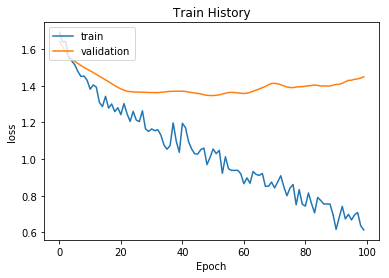

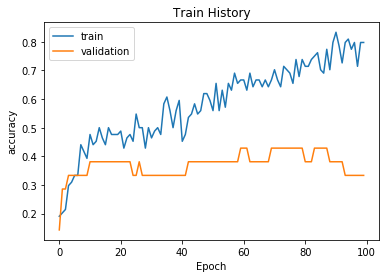

45/45 [==============================] - 0s 347us/step
Score of the Testing Data: [1.0510762373606364, 0.4444444477558136]


In [86]:
main.process_xy()
main.cnn()

### 5. 載入即時資料 

* 即時資料的時間尺度為「分」
* 載入一筆即時資料與前9筆歷史資料，共10跟K棒，進行型態預測
* 將美國時區時間轉台灣時區時間 UTC+8
* 夏令時將台灣時區開盤時間往前調整一小時

In [7]:
main.api_realtime()

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 6. 預測即時資料的型態

* 由於偵測的時間尺度為「日」，所以在交易時段內，除了收盤當下會使用當日收盤的ohlc加上前9筆歷史資料進行偵測，其餘時間都使用前一日收盤的ohlc加上往後數前9筆歷史資料來進行偵測；非交易時段則不做任何偵測。

* 尚未解決夏令與冬令交會的時段
* 尚未考慮特殊遇到假期休市的情形

W0215 00:42:18.020184  1956 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0215 00:42:18.047186  1956 module_wrapper.py:139] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0215 00:42:19.309457  1956 module_wrapper.py:139] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

C:\Users\user\Anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Mod

Target: S&P500
Time Rule: 1D
Time Period: 2020-02-01 05:00:00 - 2020-02-14 05:00:00
The Pattern of the Realtime Data: EveningStar


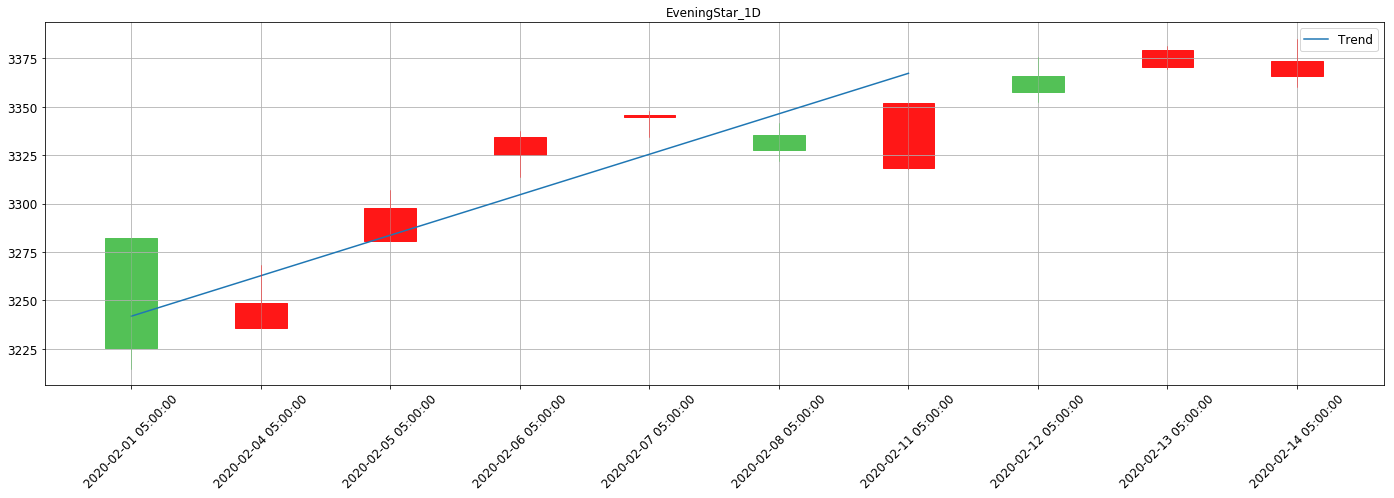

([Timestamp('2020-02-01 05:00:00'), Timestamp('2020-02-14 05:00:00')],
 'EveningStar')

In [8]:
main.predict_realtime()